# Twitter Account Analytics
- **Created by Andrés Segura Tinoco**  
- **Created on May 24, 2020**  

In [1]:
# Twitter account
from datetime import date
tw_user_name = "@SeguraAndres7"
print("Twitter account:", tw_user_name)
print("Analysis date:", date.today())

Twitter account: @SeguraAndres7
Analysis date: 2021-08-16


In [2]:
# Import util libraries
import tweepy
import random
import numpy as np
import pandas as pd
import yaml
import warnings
import calendar
import time
from PIL import Image
from collections import Counter

In [3]:
# Import NLP libraries
import re
import spacy.lang.es as es
import spacy.lang.en as en
from textblob import TextBlob
from wordcloud import WordCloud

In [4]:
# Import plot libraries
import matplotlib.pyplot as plt

In [5]:
warnings.filterwarnings('ignore')

#### Definition of Utility Functions

In [6]:
# Util function - Read dict from yaml file
def get_dict_from_yaml(yaml_path):
    result = dict()
    
    with open(yaml_path) as f:
        yaml_file = f.read()
        result = yaml.load(yaml_file, Loader=yaml.FullLoader)
    
    return result

In [7]:
# Util function - Plot column chart
def plot_col_chart(df, figsize, x_var, y_var, title, color='green', legend=None, x_label=None):
    fig, ax = plt.subplots()
    df.plot.bar(ax=ax, x=x_var, y=y_var, color=color, alpha=0.75, figsize=figsize)
    if legend:
        ax.legend(legend)
    else:
        ax.get_legend().remove()
    if x_label:
        x = np.arange(len(x_label))
        plt.xticks(x, x_label, rotation=45)
    else:
        plt.xticks(rotation=45)
    plt.title(title, fontsize=16)
    plt.xlabel(x_var.capitalize())
    plt.ylabel(y_var.capitalize())
    plt.show()

In [8]:
# Util function - Plot column chart
def plot_bar_chart(df, figsize, x_var, y_var, title, color='blue', legend=None):
    fig, ax = plt.subplots()
    df.plot.barh(ax=ax, x=x_var, y=y_var, alpha=0.75, figsize=figsize)
    if legend:
        ax.legend(legend)
    else:
        ax.get_legend().remove()
    plt.title(title, fontsize=16)
    plt.xlabel(y_var.capitalize())
    plt.ylabel(x_var.capitalize())
    plt.show()

In [9]:
# Util function - Get country from location
def get_country_from_loc(location):
    country = ''
    
    location = location.strip()
    if location != '':
        tokens = location.split(',')
        country = tokens[-1].strip()
    
    return country

## 1. Create connection to the Tweepy API

In [10]:
# Read twitter bot credentials
yaml_path = 'config/credentials.yml'
twt_login = get_dict_from_yaml(yaml_path)

# Setup bot credentials
consumer_key = twt_login['consumer_key']
consumer_secret = twt_login['consumer_secret']
access_token = twt_login['access_token']
access_token_secret = twt_login['access_token_secret']

In [11]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Create API object
api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


## 2. Query data to Tweepy API

### 2.1. Read Twitter account info

In [12]:
# Show user account details
user = api.get_user(screen_name=tw_user_name)
print("User details:")
print(user.name)
print(user.description)
print(user.location)
print(user.created_at)

User details:
Andres Segura-Tinoco
CS PhD student at @UAM_Madrid | My research interests are in: XAI, ML, RecSys, NLP, Argument Mining and Information Retrieval | Tweets in En & Es
Bogotá, DC, Colombia
2010-09-06 04:35:36


In [13]:
# Show followers/Following ratio
flw_ratio = user.followers_count / user.friends_count
print('Influence ratio:', round(flw_ratio, 2))

Influence ratio: 7.05


### 2.2. Read the list of tweets from an account

In [14]:
# Util function - Fetch tweets list from a specific user
# Note: Twitter only allows access to a users most recent 3240 tweets with this method
def get_all_tweets(api, screen_name):
    all_tweets = []
    
    # Make initial request for most recent tweets (200 is the maximum allowed count)
    try:
        new_tweets = api.user_timeline(screen_name=screen_name, count=200, tweet_mode='extended')

        # Save most recent tweets
        all_tweets.extend(new_tweets)

        # Save the id of the oldest tweet less one
        oldest = all_tweets[-1].id - 1

        # Keep grabbing tweets until there are no tweets left to grab
        while len(new_tweets) > 0:

            # All subsiquent requests use the max_id param to prevent duplicates
            new_tweets = api.user_timeline(screen_name = screen_name, count=200, tweet_mode='extended', max_id=oldest)

            # Save most recent tweets
            all_tweets.extend(new_tweets)

            # Update the id of the oldest tweet less one
            oldest = all_tweets[-1].id - 1
    
    except (socket.timeout, exceptions.ReadTimeoutError, exceptions.ProtocolError, tweepy.TweepError) as e:
        print('Error:', e)
    
    # Transform the tweepy tweets into an array that contains the relevant fields of each tweet
    tweet_list = []
    for tweet in all_tweets:
        new_tweet = {
            'id': tweet.id_str,
            'created_at': tweet.created_at,
            'message': tweet.full_text,
            'lang': tweet.lang,
            'hashtags': [ht['text'] for ht in tweet.entities['hashtags']],
            'user_mentions': [mt['screen_name'] for mt in tweet.entities['user_mentions']],
            'retweet_count': tweet.retweet_count,
            'favorite_count': tweet.favorite_count,
            'retweeted': tweet.retweeted,
            'source': tweet.source,
            'display_text_range': tweet.display_text_range
        }
        tweet_list.append(new_tweet)
    
    return tweet_list

In [15]:
# Fetching tweet list from a specific user
raw_tweet_list = get_all_tweets(api, screen_name=tw_user_name)
len(raw_tweet_list)

965

In [16]:
# Show the last tweet
raw_tweet_list[0]

{'id': '1427259243661561866',
 'created_at': datetime.datetime(2021, 8, 16, 13, 21, 35),
 'message': 'What an amazing birthday present I have received from my beloved wife @sarilexs \n\nOne more @LEGO_Group for my collection. This Is The Way! https://t.co/Qtk6TYF6IO',
 'lang': 'en',
 'hashtags': [],
 'user_mentions': ['sarilexs', 'LEGO_Group'],
 'retweet_count': 0,
 'favorite_count': 5,
 'retweeted': False,
 'source': 'Twitter for iPhone',
 'display_text_range': [0, 138]}

### 2.3. Calculate own tweet rate

In [17]:
tweet_list = [tweet for tweet in raw_tweet_list if not tweet['retweeted'] and not tweet['message'].startswith("RT ")]
own_tweet_rate = len(tweet_list) / len(raw_tweet_list)
print("Own tweet rate: %.2f" % own_tweet_rate)
print("Total own tweets:", len(tweet_list))

Own tweet rate: 0.96
Total own tweets: 929


## 3. Followers Basic Analytics

### 3.1. List of Followers

In [18]:
# Get a list of all followers of a twitter account
followers = []
for page in tweepy.Cursor(api.followers, screen_name=tw_user_name, wait_on_rate_limit=True, count=200).pages():
    try:
        followers.extend(page)
    except tweepy.TweepError as e:
        time.sleep(10)

n_followers = len(followers)
print('Number of followers: %s' % n_followers)

Number of followers: 1572


### 3.2. Followers Account Creation

In [19]:
# Get year the account was created
flw_creation = Counter()
for flw in followers:
    created_at = flw.created_at.date()
    year = created_at.year
    flw_creation[year] += 1

In [20]:
# Cooking dataframe
df = pd.DataFrame.from_records(flw_creation.most_common(), columns = ['year', 'frequency']).sort_values(by=['year'])

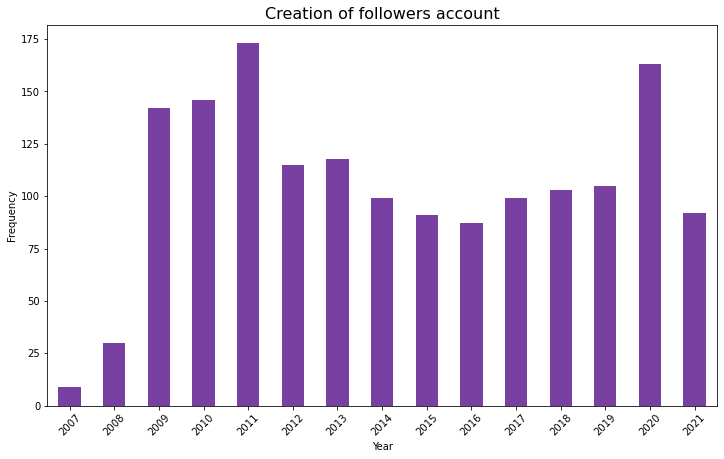

In [21]:
# Plot creation of followers account
figsize = (12, 7)
x_var = 'year'
y_var = 'frequency'
title = 'Creation of followers account'
color = 'indigo'
plot_col_chart(df, figsize, x_var, y_var, title, color)

### 3.3. Followers Location

In [22]:
# Get followers location
flw_location = Counter()
for flw in followers:
    location = flw.location
    country = get_country_from_loc(location)
    if country != '':
        flw_location[country] += 1

loc_ratio = sum(flw_location.values()) / n_followers * 100
print('Number of followers with location:', round(loc_ratio, 2), '%')

Number of followers with location: 57.0 %


In [23]:
# Cooking dataframe
df = pd.DataFrame.from_records(flw_location.most_common(), columns=['location', 'frequency'])
df = df.sort_values(by=['frequency'], ascending=False)
df = df.loc[(df['frequency'] >= 2)]
df

,location,frequency
0,India,142
1,Colombia,29
2,CA,22
3,Nigeria,17
4,England,14
...,...,...
74,Россия,2
72,Distrito Federal,2
71,Melbourne,2
70,Tanzania,2


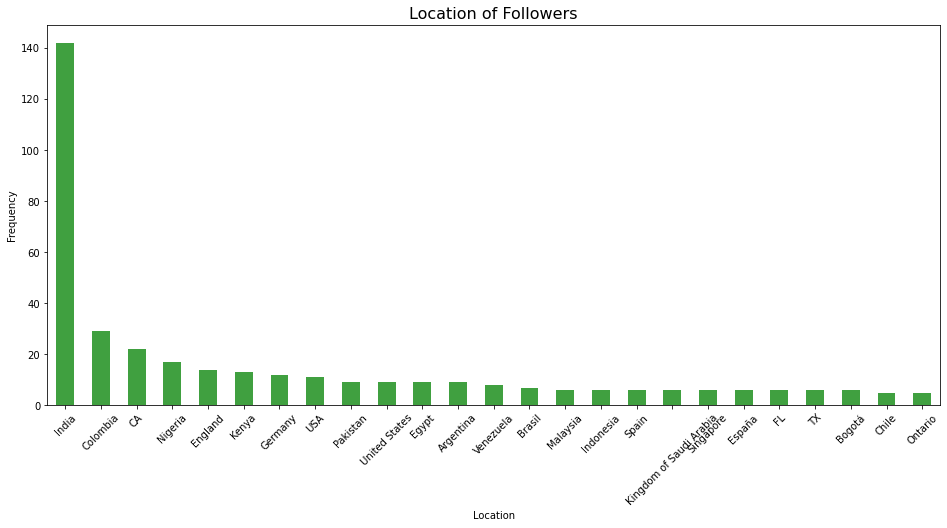

In [24]:
# Plot top N mentioned accounts
x_var = 'location'
y_var = 'frequency'
title = 'Location of Followers'
figsize = (16, 7)
plot_col_chart(df.head(25), figsize, x_var, y_var, title)

### 3.4. Stats of Following & Followers

In [25]:
# Get year the account was created
flw_following_count = []
flw_followers_count = []

for flw in followers:
    flw_following_count.append(flw.friends_count)
    flw_followers_count.append(flw.followers_count)

In [26]:
# Accounts followed per followers
print(">> Accounts followed per followers")
print('Average number: %.2f' % np.mean(flw_following_count))
print('Median number: %.2f' % np.median(flw_following_count))

>> Accounts followed per followers
Average number: 1835.35
Median number: 536.00


In [27]:
# Number of followers of my followers
print(">> Number of followers of my followers")
print('Average number: %.2f' % np.mean(flw_followers_count))
print('Median number: %.2f' % np.median(flw_followers_count))

>> Number of followers of my followers
Average number: 4268.09
Median number: 71.00


## 4. Tweets Basic Analytics

### 4.1. Length of Tweets

In [28]:
# Tweet length
n_tweets = len(tweet_list)
tweets_len = []

for tweet in tweet_list:
    tweets_len.append(len(tweet['message']))

In [29]:
# Showing stats
print('Number of tweets: %s' % n_tweets)
print('Minimum length: %s' % np.min(tweets_len))
print('Maximum length: %s' % np.max(tweets_len))
print('Average length: %.2f' % np.mean(tweets_len))
print('Standard deviation: %.2f' % np.std(tweets_len))

Number of tweets: 929
Minimum length: 15
Maximum length: 319
Average length: 203.91
Standard deviation: 72.27


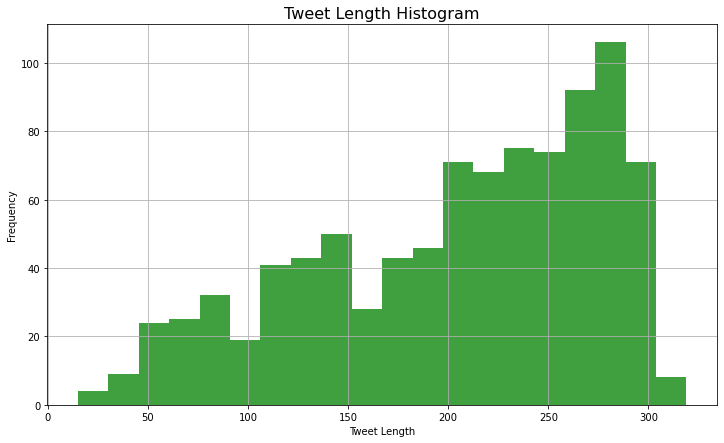

In [30]:
# Plot histograma of the tweet length
fig = plt.figure(figsize = (12, 7))
plt.hist(tweets_len, 20, facecolor='green', alpha=0.75)
plt.title('Tweet Length Histogram', fontsize=16)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 4.2. Stats of Retweets and Favorites

In [31]:
# Get retweet and favorite stats
retweet_count = []
favorite_count = []

for tweet in tweet_list:
    retweet_count.append(tweet['retweet_count'])
    favorite_count.append(tweet['favorite_count'])

In [32]:
# Showing statistics of account tweets
print('Retweets total: %s' % np.sum(retweet_count))
print('Retweets average: %.2f' % np.mean(retweet_count))
print('Favorites total: %s' % np.sum(favorite_count))
print('Favorites average: %.2f' % np.mean(favorite_count))

Retweets total: 1478
Retweets average: 1.59
Favorites total: 8968
Favorites average: 9.65


In [33]:
# Top 15 most popular tweets
df = pd.DataFrame(tweet_list)
df.drop('id', axis=1, inplace=True)
df.drop('source', axis=1, inplace=True)
df.drop('user_mentions', axis=1, inplace=True)
df.drop('retweeted', axis=1, inplace=True)
df.drop('display_text_range', axis=1, inplace=True)
df.sort_values(by=['retweet_count', 'favorite_count'], ascending=False).head(15)

,created_at,message,lang,hashtags,retweet_count,favorite_count
144,2021-07-07 20:23:53,"I have been working on 3 free, hands-on Python...",en,[],393,1593
399,2021-04-15 21:29:08,Why is there such a difference in the results ...,en,[],59,307
299,2021-05-13 19:31:22,Correlation is the degree and direction in whi...,en,[DataAnalytics],51,337
199,2021-06-19 19:00:15,Let me share with you 3 definitions of what Ma...,en,[],48,276
156,2021-07-02 16:11:24,Feature Scaling is one of the most useful and ...,en,[],47,237
306,2021-05-10 02:53:45,12 cool and useful NLP libraries🧵\n\n1. NLTK: ...,en,[],43,218
281,2021-05-17 19:38:09,I am working on this new project 👨‍💻\n\nA prac...,en,[],38,145
103,2021-07-23 20:24:10,It is amazing how much information can be obta...,en,[],35,190
406,2021-04-13 19:31:36,Clustering is one of the most common applicati...,en,[],35,147
59,2021-08-04 19:22:18,A common practice when we create NLP models is...,en,[],25,164


### 4.3. Tweets Language

In [34]:
# Read iso639_2 languages codes
filename = 'config\iso_lang_codes.csv'
df = pd.read_csv(filename, names = ['iso_code', 'language'], skiprows=1)
lang_dict = dict(zip(list(df.iso_code), list(df.language)))
print('Languages dict length:', len(lang_dict))

Languages dict length: 185


In [35]:
# Count the language of the tweets
lang_list = Counter()

for tweet in tweet_list:
    tweet_lang = tweet['lang']
    if tweet_lang in lang_dict.keys():
        lang = lang_dict[tweet['lang']]
        lang_list[lang] += 1
    else:
        print('Missing:', tweet_lang)

print('Total tweets language: %s' % len(lang_list))

Total tweets language: 3


In [36]:
# Cooking dataframe
df = pd.DataFrame.from_records(lang_list.most_common(), columns = ['language', 'frequency'])

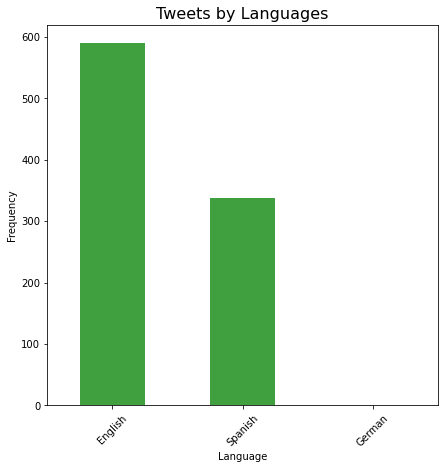

In [37]:
# Plot the language of the tweets
x_var = 'language'
y_var = 'frequency'
title = 'Tweets by Languages'
figsize = (7, 7)
plot_col_chart(df, figsize, x_var, y_var, title)

### 4.4. Tweets by Day of Week and by Year

In [38]:
# Count the language of the tweets
tweets_year = Counter()
tweets_day = Counter()

for tweet in tweet_list:
    created_at = tweet['created_at'].date()
    weekday = created_at.weekday()
    year = created_at.year
    
    tweets_day[weekday] += 1
    tweets_year[year] += 1

In [39]:
# Cooking dataframe
df = pd.DataFrame.from_records(list(tweets_day.items()), columns = ['weekday', 'frequency']).sort_values(by=['weekday'])
x = np.arange(7)
x_label = [calendar.day_name[d] for d in x]

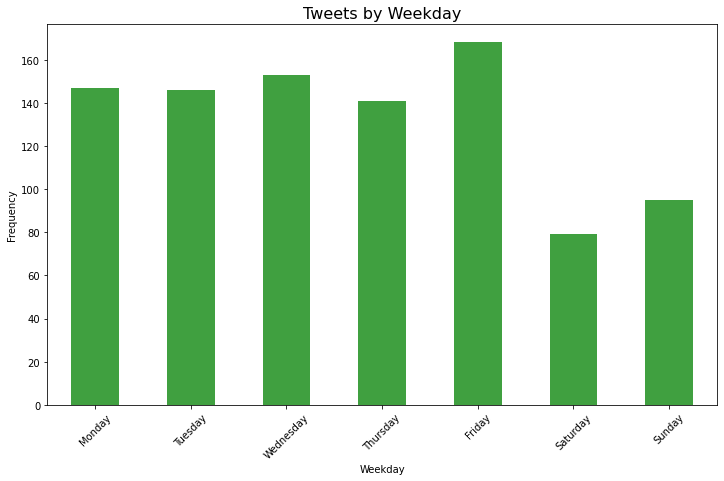

In [40]:
# Plot tweets by weekday
x_var = 'weekday'
y_var = 'frequency'
title = 'Tweets by Weekday'
figsize = (12, 7)
color = 'green'
x_label = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot_col_chart(df, figsize, x_var, y_var, title, color, None, x_label)

In [41]:
# Cooking dataframe
df = pd.DataFrame.from_records(tweets_year.most_common(), columns = ['year', 'frequency']).sort_values(by=['year'])

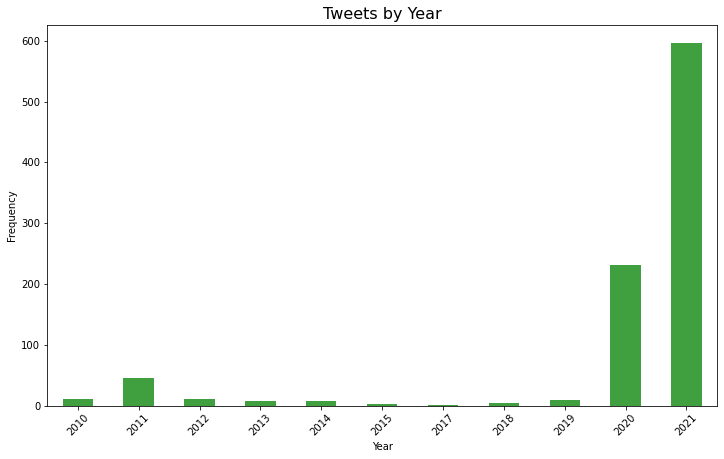

In [42]:
# Plot tweets by year
x_var = 'year'
y_var = 'frequency'
title = 'Tweets by Year'
figsize = (12, 7)
plot_col_chart(df, figsize, x_var, y_var, title)

### 4.5. Tweeting Sources

In [43]:
# Count the source of the tweets
tweets_source = Counter()

for tweet in tweet_list:
    year = tweet['source']
    tweets_source[year] += 1

print('Total tweeting sources: %s' % len(tweets_source))

Total tweeting sources: 7


In [44]:
# Cooking dataframe
df = pd.DataFrame.from_records(tweets_source.most_common(), columns = ['source', 'frequency'])

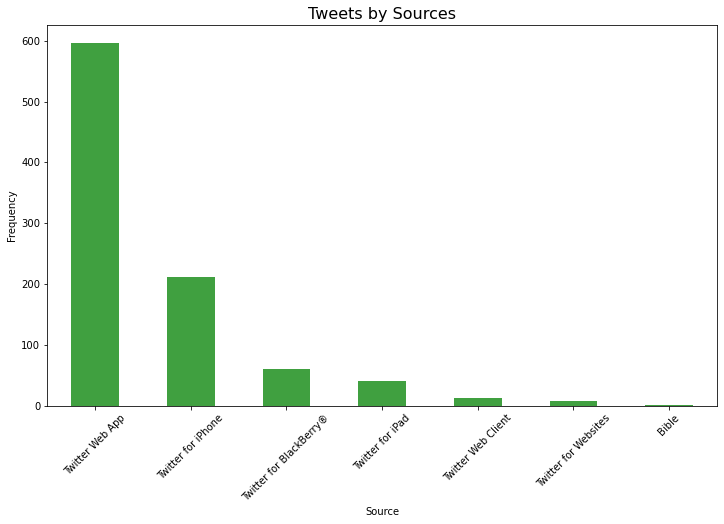

In [45]:
# Plot tweeting Sources
x_var = 'source'
y_var = 'frequency'
title = 'Tweets by Sources'
figsize = (12, 7)
plot_col_chart(df, figsize, x_var, y_var, title)

## 5. NLP Analytics

In [46]:
# Util function - Clean tweet text
def dq_clean_text(text):
    clean_text = text.lower()
    clean_text = re.sub(rx, ' ', clean_text)
    clean_text = re.sub(r'\.+', ' ', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text)
    return clean_text

In [47]:
# Global NLP variables
n_top = 20
punt_marks = ['\n', '\'', '\\', '/', '¡', '!', '¿', '?', '.', ',', ';', ':', '_', '-', '#', '$', '%', '&', '(', ')', '"']
rx = '[' + re.escape(''.join(punt_marks)) + ']'

In [48]:
# Counter of used words
word_list = Counter()

# Create list of words
for tweet in tweet_list:
    tweet_text = tweet['message']
    
    # Clean tweet text
    clean_text = dq_clean_text(tweet_text)
    
    # Save mentioned accounts
    for word in clean_text.split(' '):
        if len(word) and not word.isnumeric():
            word_list[word] += 1

print('Number of words used: %s' % len(word_list))
print('Average words per tweet: %.2f' % (len(word_list) / n_tweets))

Number of words used: 5826
Average words per tweet: 6.27


### 5.1. Most mentioned User Accounts

In [49]:
# Most mentioned accounts list
tw_accounts = Counter()

# Save mentioned accounts
for word, freq in list(word_list.items()):
    if word[0] == '@' and word != tw_user_name and len(word) > 1:
        tw_accounts[word] = freq

print('Total different mentioned accounts: %s' % len(tw_accounts))
print('Average mentioned accounts per tweet: %.2f' % (sum(tw_accounts.values())/n_tweets))

Total different mentioned accounts: 190
Average mentioned accounts per tweet: 0.42


In [50]:
# Cooking dataframe
top_accounts = tw_accounts.most_common(n_top)
df = pd.DataFrame.from_records(top_accounts, columns = ['account', 'frequency']).sort_values(by=['frequency'])

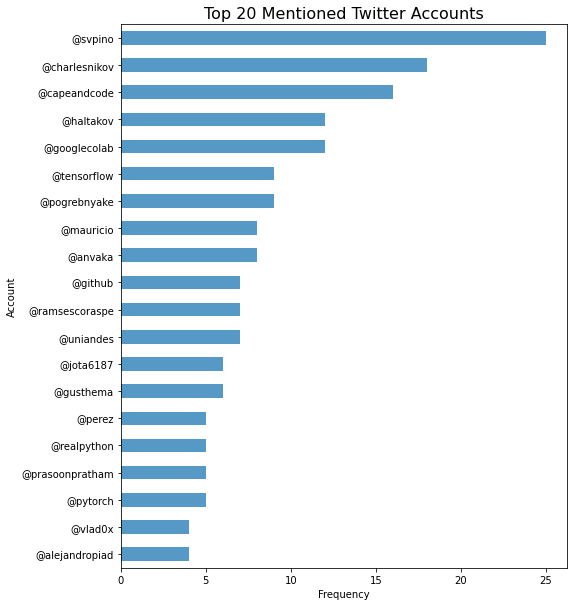

In [51]:
# Plot top N mentioned accounts
x_var = 'account'
y_var = 'frequency'
title = 'Top %s Mentioned Twitter Accounts' % n_top
figsize = (8, 10)
plot_bar_chart(df, figsize, x_var, y_var, title)

### 5.2. Most used Hashtags in Tweets

In [52]:
# Count the hashtags in the tweets and return the N most repeated 
hashtags = Counter()

for t in tweet_list:
    for ht in t['hashtags']:
        ht = '#'+ht.lower()
        hashtags[ht] += 1

print('Total used different hashtags: %s' % len(hashtags))
print('Average hashtags per tweet: %.2f' % (sum(hashtags.values())/n_tweets))

Total used different hashtags: 113
Average hashtags per tweet: 0.42


In [53]:
# Cooking dataframe
top_hashtags = hashtags.most_common(n_top)
df = pd.DataFrame.from_records(top_hashtags, columns = ['hashtag', 'frequency']).sort_values(by=['frequency'])

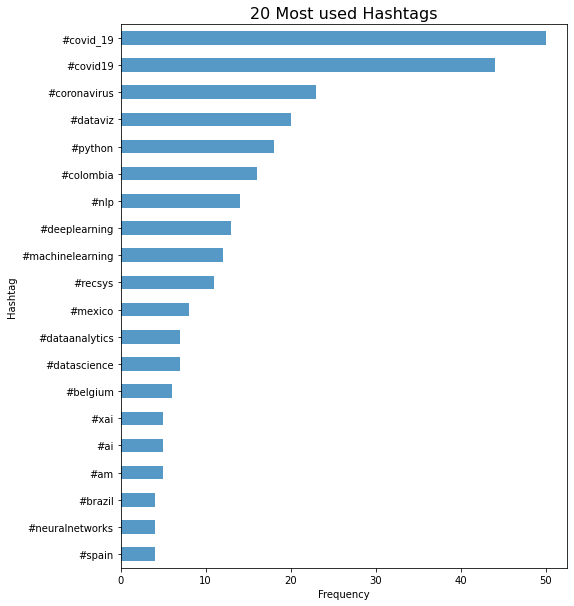

In [54]:
# Plot the most common hashtags in tweets
x_var = 'hashtag'
y_var = 'frequency'
title = '%s Most used Hashtags' % n_top
figsize = (8, 10)
plot_bar_chart(df, figsize, x_var, y_var, title)

### 5.3. Most common Words in Tweets

In [55]:
# Add word-freq to Dataframe
df = pd.DataFrame(columns=['word', 'frequency'])
ix = 0

# Filter twitter accounts
for word, freq in word_list.most_common():
    if ix == n_top:
        break
    elif len(word) > 2 and word[0] != '@':
        df.loc[ix] = (word, freq)
        ix += 1

# Sorting data by frequency
df = df.sort_values(by=['frequency'])

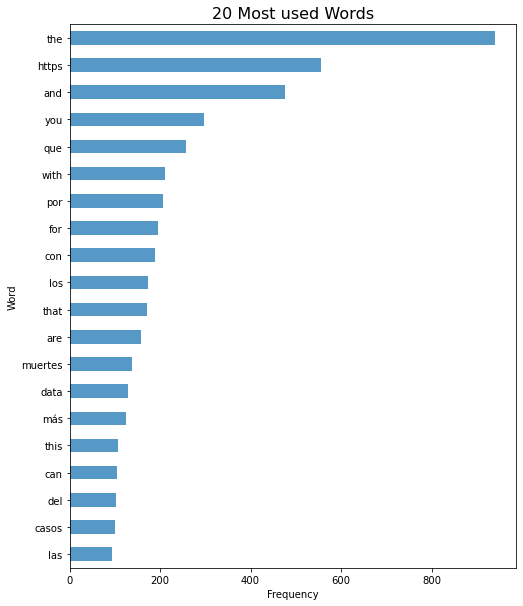

In [56]:
# Plot the most common words in tweets
x_var = 'word'
y_var = 'frequency'
title = '%s Most used Words' % n_top
figsize = (8, 10)
plot_bar_chart(df, figsize, x_var, y_var, title)

### 5.4. Most common Words w/o Stopwords

In [57]:
# Get Spanish stopwords
stopwords_es = es.stop_words.STOP_WORDS
stopwords_en = en.stop_words.STOP_WORDS | set({'http', 'https'})

In [58]:
# Add word-freq to Dataframe
df = pd.DataFrame(columns=['word', 'frequency'])
ix = 0

# Filter English and Spanihs stopwords
for word, freq in word_list.most_common():
    if ix == n_top:
        break
    elif (word not in stopwords_es) and (word not in stopwords_en) and (len(word) > 2) and (word[0] != '@'):
        df.loc[ix] = (word, freq)
        ix += 1

# Sorting data by frequency
df = df.sort_values(by=['frequency'])

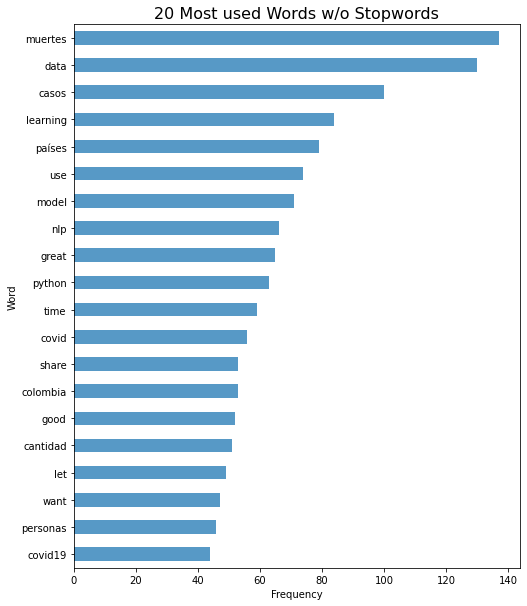

In [59]:
# Plot the most common words in tweets
x_var = 'word'
y_var = 'frequency'
title = '%s Most used Words w/o Stopwords' % n_top
figsize = (8, 10)
plot_bar_chart(df, figsize, x_var, y_var, title)

### 5.5. Most common Bigrams  w/o Stopwords

In [60]:
# Calculate most common bigrams and reconstruct full text with used words
new_clean_text = user.description
bigram_list = Counter()

# Create list of words
for tweet in tweet_list:
    tweet_text = tweet['message']
    clean_text = dq_clean_text(tweet_text)
    
    tokens = clean_text.split(' ')
    bigram = ''
    last_word = ''
    for i in range(0, len(tokens)):
        word = tokens[i]
        if (word not in stopwords_es) and (word not in stopwords_en) and (len(word) > 2) and (word[0] != '@'):
            
            # Reconstructing the clean text (without stop-words)
            new_clean_text += ' ' + word
            
            # Add bigrams-freq to Dataframe
            if last_word != "":
                bigram = last_word + '-' + word
                bigram_list[bigram] += 1
            
            last_word = word

print('Total different bigrams: %s' % len(bigram_list))

Total different bigrams: 11288


In [61]:
# Cooking dataframe
top_bigrams = bigram_list.most_common(n_top)
df = pd.DataFrame.from_records(top_bigrams, columns = ['bigram', 'frequency']).sort_values(by=['frequency'])

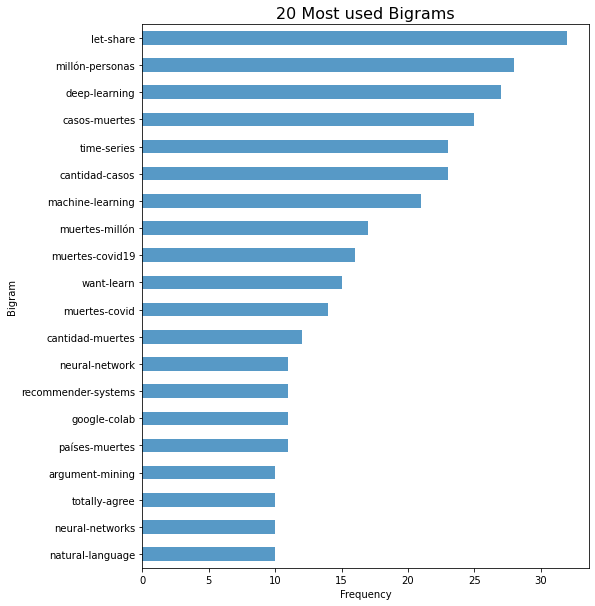

In [62]:
# Plot the most common words in tweets
x_var = 'bigram'
y_var = 'frequency'
title = '%s Most used Bigrams' % n_top
figsize = (8, 10)
plot_bar_chart(df, figsize, x_var, y_var, title)

### 5.6. Tweet WordCloud

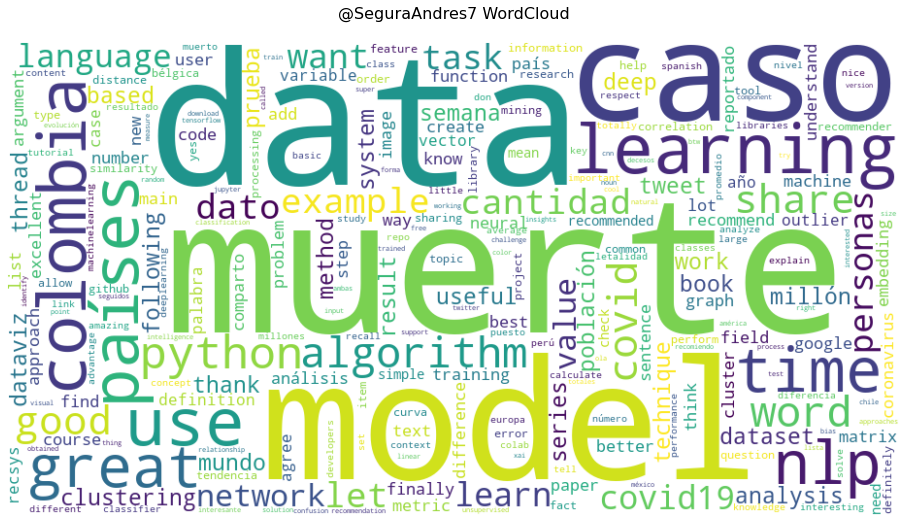

In [63]:
# Import mask
mask = np.array(Image.open('../img/twitter-mask.png'))

# Create a Word-cloud
wc = WordCloud(background_color="white", max_words=250, mask=mask, collocations=False, margin=2)
wc = wc.generate(new_clean_text)

# Plot a Word-cloud of words of tweets
plt.figure(figsize = (16, 10))
image = plt.imshow(wc, interpolation = "bilinear")
plt.title('%s WordCloud\n' % tw_user_name, fontsize=16)
plt.axis("off")

# Save the Word-cloud image
plt.savefig('../img/wordcloud.png')
plt.show()

## 6. Sentiment Analysis

Sentiment analysis is done with the TextBlob library. Tweets that were not written in English are previously translated.

In [64]:
# Functions to discretize the sentiment analysis results
def get_polarity(polarity):
    if polarity >= 0.20:
        return 'positive'
    elif polarity <= -0.20:
        return 'negative'
    return 'neutral'

def get_subjectivity(subjectivity):
    if subjectivity >= 0.5:
        return 'subjective'
    return 'objective'

In [65]:
# Calculate the sentiment of the tweet
allow_translation = True
lang_dest = 'en'
polarity_list = Counter({'positive': 0, 'negative': 0, 'neutral': 0})
subjectivity_list = Counter({'subjective': 0, 'objective': 0})

for tweet in tweet_list:
    message = tweet['message']
    lang_source = tweet['lang']
    
    # If the language of the tweet is different from English, it is translated
    if lang_source == lang_dest or allow_translation:
        analysis = TextBlob(message)
        try:
            if lang_source != lang_dest:
                analysis = analysis.translate(to=lang_dest)
                time.sleep(0.1)
            
            # Apply sent-analysis
            polarity = get_polarity(analysis.sentiment.polarity)
            subjectivity = get_subjectivity(analysis.sentiment.subjectivity)

            # Save results
            polarity_list[polarity] += 1
            subjectivity_list[subjectivity] += 1
        except:
            pass

In [66]:
# Cooking dataframe
df = pd.DataFrame.from_records(list(polarity_list.items()), columns = ['polarity', 'frequency'])
df['perc'] = (100 * df['frequency'] / sum(df['frequency']))
df

,polarity,frequency,perc
0,positive,430,47.252747
1,negative,24,2.637363
2,neutral,456,50.109890


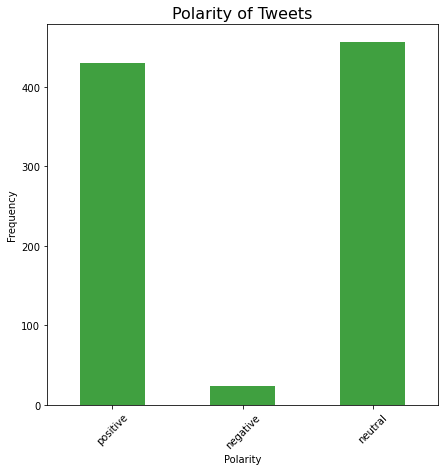

In [67]:
# Plot the polarity of tweets
x_var = 'polarity'
y_var = 'frequency'
title = 'Polarity of Tweets'
figsize = (7, 7)
plot_col_chart(df, figsize, x_var, y_var, title)

In [68]:
# Cooking dataframe
df = pd.DataFrame.from_records(list(subjectivity_list.items()), columns = ['subjectivity', 'frequency'])
df['perc'] = (100 * df['frequency'] / sum(df['frequency']))
df

,subjectivity,frequency,perc
0,subjective,420,46.153846
1,objective,490,53.846154


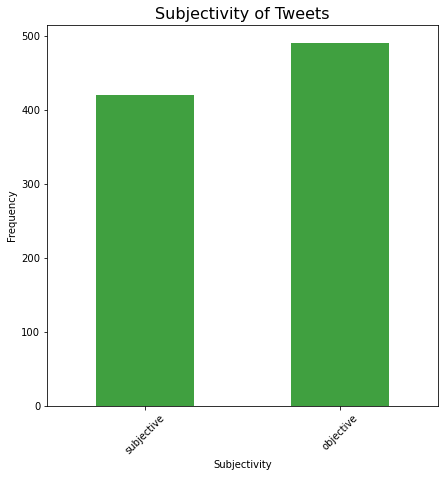

In [69]:
# Plot the subjectivity of tweets
x_var = 'subjectivity'
y_var = 'frequency'
title = 'Subjectivity of Tweets'
figsize = (7, 7)
plot_col_chart(df, figsize, x_var, y_var, title)

<hr>
<p><a href="https://github.com/ansegura7/TwitterAnalytics">« Home</a></p>